In [218]:
#Load dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [219]:
torch.manual_seed(42) #random number seed using 42 because it's the answer to life

In [220]:
# Generate training dataset
# training data consists of 1024 pairs (x1,x2) which correspond to coordinates of the Torricelli's function
# we use a multiple of 32 since we will set batch size to 32.
# between 0 and 5

train_data_length = 1024 #set length
train_data = torch.zeros((train_data_length, 2)) #create two columns of 1024
train_data[:, 0] = 5 * torch.rand(train_data_length) #load 1024 values of x1 between 0 and 5
train_data[:, 1] = 1/(train_data[:, 0]) #calculate 1024 values of x2 based on x1
train_labels = torch.zeros(train_data_length) #create indexes for data instances

#Create variable with training data and ordered labels
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

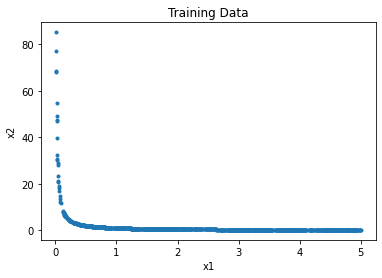

In [221]:
#Visualize training data
plt.plot(train_data[:, 0], train_data[:, 1], ".")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Data')
plt.show()

In [222]:
# segment all the data into 32 batches
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [223]:
### Setting up the discriminator agent ###

# 4 feedforward linear layers, with leaky ReLU and dropouts after the first three and sigmoid threshold after the final layer

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( ### sequential MLP network 
            nn.Linear(2, 256), # 2 dimensional data (x1, x2), and first layer contains 256 neurons
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), # second layer contains 128 layers
            nn.LeakyReLU(), ###nn.leakyReLu
            nn.Dropout(0.3), #use dropout function after each layer to prevent overfitting
            nn.Linear(128, 64), # third layer contains 64 layers
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1), #single neuron output
            nn.Sigmoid(),) #sigmoidal probability threshold

    def forward(self, x):
        output = self.model(x)
        return output

In [224]:
# Activate discriminator

discriminator = Discriminator()

In [225]:
### Setting up the generator network ###

# Simple multilayer perceptron with three feedforward layers

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16), #2 variables and 16 neurons in the first layer
            nn.ReLU(),
            nn.Linear(16, 32), #32 neurons in the second layer
            nn.ReLU(),
            nn.Linear(32, 2),) #2 neurons in the output layer

    def forward(self, x):
        output = self.model(x)
        return output

In [226]:
# Activate generator

generator = Generator()

In [227]:
# Training

# Parameters

learning_rate = 0.002
n_epochs = 50
loss_function = nn.BCELoss() # Mean Squared Error Loss function, can change to nn.BCELoss (binary cross entropy loss) 
# or L1Loss or CrossEntropyLoss

In [228]:
# Create Optimizers

optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)

In [229]:
# Implement training loop

Dloss = [] # empty list to store loss values
Gloss = []

for epoch in range(n_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_D.step()
        
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))
        
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_gen = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_gen, real_samples_labels)
        loss_generator.backward()
        optimizer_G.step()
        
        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
        
        if epoch % 1 == 0 and n == batch_size - 1:    
            Dloss.append(loss_discriminator.detach())
            Gloss.append(loss_generator.detach())

Epoch: 0 Loss D.: 0.10074030607938766
Epoch: 0 Loss G.: 4.416480541229248
Epoch: 10 Loss D.: 0.6485685110092163
Epoch: 10 Loss G.: 0.7448774576187134
Epoch: 20 Loss D.: 0.6560580730438232
Epoch: 20 Loss G.: 0.7643178105354309
Epoch: 30 Loss D.: 0.5440322160720825
Epoch: 30 Loss G.: 1.5029340982437134
Epoch: 40 Loss D.: 0.6888387203216553
Epoch: 40 Loss G.: 0.6952170133590698


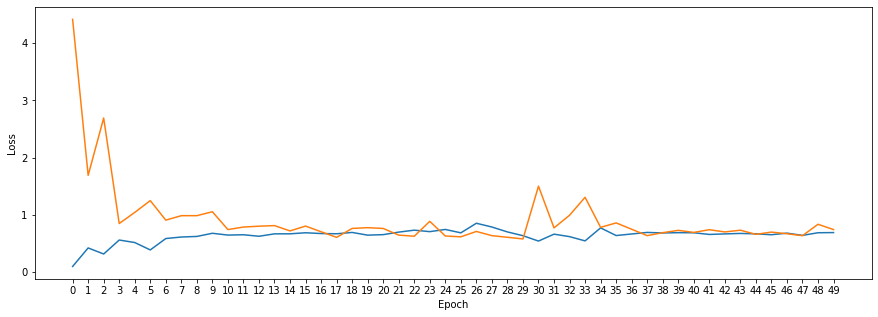

In [230]:
#plt.scatter(n_epochs, loss_discriminator.detach())
lossfig = plt.figure(figsize=(15,5))
plt.plot(Dloss)
plt.plot(Gloss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, n_epochs))
plt.show()

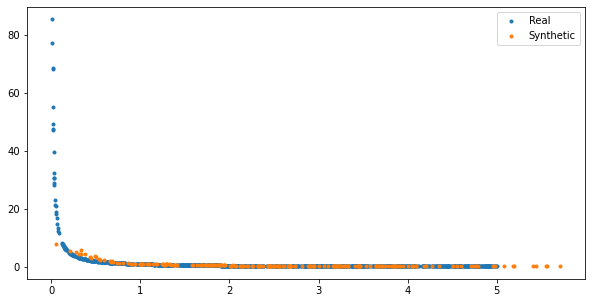

In [231]:
latent_space_samples = torch.randn(200, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
fig = plt.figure(figsize=(10,5))
plt.plot(train_data[:, 0], train_data[:, 1], ".", label='Real')
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".", label='Synthetic')
plt.legend()
plt.show()

In [200]:
#### We can observe in this visual comparison between training data and generated data, that the GAN can map
# the Torricelli function from the latent space, however we notice this problem of mode collapse. Observing close
# zero, the generator struggles to generate samples on the ascending portion of the curve. The generator is focussing
# too much on the other features of the dataset.

# Play around with parameters (learing rate, optimizer choice, loss function choise, number of epochs and network
# architectural paramters) to see if we can find a set of hyperparameters to best represent this function.